## Read 2pt for test

In [2]:
import numpy as np
import gvar as gv

from lametlat.utils.plot_settings import *
from lametlat.preprocess.read_raw import pt2_to_meff, pt2_to_meff_solve
from lametlat.utils.resampling import bootstrap, bs_ls_avg, jackknife, jk_ls_avg
from lametlat.gsfit.Lanczos.t_matrix import T_Matrix, cut_spurious
from lametlat.utils.constants import *
from lametlat.utils.funcs import constant_fit

a = 0.06
Ls = 48
N_conf = 100
qprop_corr = []
with open("data/qprop_1008_1608.txt", "r") as f:
    next(f)  # Skip header row
    for line in f:
        if line.strip():
            parts = line.strip().split()
            # Extract complex number from string like (a+bj)
            complex_str = parts[2].strip("()")
            qprop_corr.append(complex(complex_str))

# Reshape into 2D array with shape (N_conf, z)
qprop_corr_data = np.array(qprop_corr).reshape(N_conf, Ls)
qprop_corr_jk = jackknife(qprop_corr_data)
print(np.shape(qprop_corr_jk))

(100, 48)


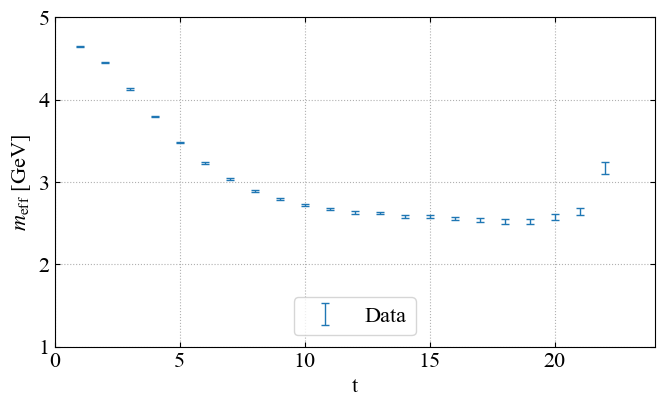

In [7]:
meff_jk = [pt2_to_meff(qprop_corr_jk[i], boundary="none") for i in range(len(qprop_corr_jk))]
meff_avg = jk_ls_avg(meff_jk) * GEV_FM / a

fig, ax = default_plot()
ax.errorbar(np.arange(len(meff_avg)), gv.mean(meff_avg), yerr=gv.sdev(meff_avg), label='Data', **errorb)
ax.set_xlabel('t', **fs_p)
ax.set_ylabel(r'$m_{\rm eff}$ [GeV]', **fs_p)
plt.ylim(1., 5)
plt.xlim(0, 24)
plt.legend(**fs_p)
plt.tight_layout()
plt.show()

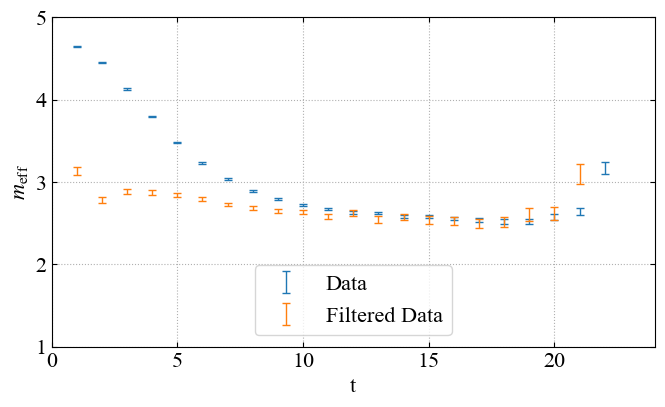

In [15]:
def laplace_filter(pt2_data, lam):
    """
    D_lam C(t) = C(t + 1) - (2 + lam ** 2) C(t) + C(t - 1)
    """
    return np.diff(pt2_data, 2) - (lam ** 2) * pt2_data[1:-1]
    
    # return pt2_data[2:] - (2 + lam ** 2) * pt2_data[1:-1] + pt2_data[:-2]

e1 = 5 * a / GEV_FM
lam = np.sqrt( 2 * ( np.cosh(e1) - 1 ) )

qprop_corr_filter_jk = [laplace_filter(qprop_corr_jk[i], lam) for i in range(len(qprop_corr_jk))]
meff_corr_filter_jk = [pt2_to_meff(qprop_corr_filter_jk[i], boundary="none") for i in range(len(qprop_corr_filter_jk))]
meff_corr_filter_avg = jk_ls_avg(meff_corr_filter_jk) * GEV_FM / a

fig, ax = default_plot()
ax.errorbar(np.arange(len(meff_avg)), gv.mean(meff_avg), yerr=gv.sdev(meff_avg), label='Data', **errorb)
ax.errorbar(np.arange(len(meff_corr_filter_avg)), gv.mean(meff_corr_filter_avg), yerr=gv.sdev(meff_corr_filter_avg), label='Filtered Data', **errorb)
ax.set_xlabel('t', **fs_p)
ax.set_ylabel(r'$m_{\rm eff}$', **fs_p)
plt.ylim(1., 5)
plt.xlim(0, 24)
plt.legend(**fs_p)
plt.tight_layout()
plt.show()

In [10]:
n_conf = 0
m = 4
pt2_norm = qprop_corr_jk[n_conf] / qprop_corr_jk[n_conf][0]

t_matrix_class = T_Matrix(pt2_norm, m=4)
t_matrix = t_matrix_class.main(ifcheck=True)

>>> check the alpha 2 from the t-matrix:  (0.7617385756421782+13896.373536677049j)
>>> check the alpha 2 from the pt2:  (0.7617385756421777+13896.373536677043j)


ValueError: 'x' and 'y' must have the same size

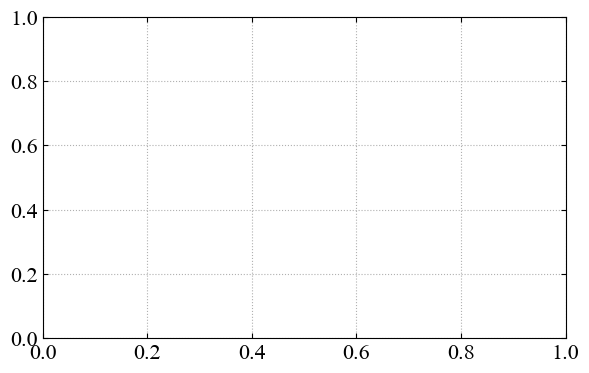

In [12]:
m_ls = np.arange(5, 24)
e0_gv, e1_gv = [], []


for m in m_ls:
    temp_e0, temp_e1 = [], []
    
    for n_conf in range(len(qprop_corr_jk)):
        pt2_norm = qprop_corr_jk[n_conf] / qprop_corr_jk[n_conf][0]
        
        t_matrix_class = T_Matrix(pt2_norm, m=m)
        t_matrix = t_matrix_class.main(ifcheck=False)
        
        if np.isnan(t_matrix).any():
            print(f"NaN detected in t_matrix for m={m} and n_conf={n_conf}")
            print(t_matrix)
            
        # Calculate eigenvalues of the t_matrix
        eigenvalues = cut_spurious(t_matrix, tolerance=0.1)
        # Select eigenvalues with imaginary part smaller than threshold
        eigenvalues = eigenvalues[np.abs(eigenvalues.imag) < 1e-8].real
        # Calculate energy states
        energy_states = - GEV_FM / a * np.log( eigenvalues )
        energy_states = np.array([e for e in energy_states if not np.isnan(e) and e > 0])
        energy_states = np.sort(energy_states)
        
        if len(energy_states) > 1 and 1 > energy_states[0] > 0.1: # todo: constrain the range of g.s. energy
            temp_e0.append(energy_states[0])
            temp_e1.append(energy_states[1])

    if len(temp_e0) > 0 and len(temp_e1) > 0:
        e0_gv.append(bs_ls_avg(temp_e0))
        e1_gv.append(bs_ls_avg(temp_e1))


fig, ax = default_plot()
ax.errorbar(m_ls, gv.mean(e0_gv), yerr=gv.sdev(e0_gv), label='Ground state', **errorb)
ax.errorbar(m_ls, gv.mean(e1_gv), yerr=gv.sdev(e1_gv), label='First excited state', **errorb)
ax.set_xlabel('m', **fs_p)
ax.set_ylabel('Energy / GeV', **fs_p)
ax.set_ylim(auto_ylim([np.array(gv.mean(e0_gv)), np.array(gv.mean(e1_gv))], [np.array(gv.sdev(e0_gv)), np.array(gv.sdev(e1_gv))]))
plt.legend(loc='upper right', **fs_p)
plt.tight_layout()
plt.show()


fig, ax = default_plot()
ax.errorbar(np.arange(len(meff_avg)), gv.mean(meff_avg), yerr=gv.sdev(meff_avg), label='Data', **errorb)
ax.errorbar(m_ls, gv.mean(e0_gv), yerr=gv.sdev(e0_gv), label='Lanczos', marker='x', color=red, **errorb)
ax.set_xlabel('t (m)', **fs_p)
ax.set_ylabel(r'$m_{\rm eff}$', **fs_p)
plt.ylim(-0.2, 0.8)
plt.legend(**fs_p)
plt.tight_layout()
plt.show()

print(">>> Ground state energy: ", gv.mean(e0_gv))
